## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./saved_models/diffusion_model_finetuned.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth (m)", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    yticks_ix = np.array(ax[0].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[0].set_yticklabels(depth_label, rotation=0)
    ax[0].collections[0].colorbar.set_label("Actual Temperature ($^\circ$C)")

    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)")
    yticks_ix = np.array(ax[1].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[1].set_yticklabels(depth_label, rotation=0)
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    yticks_ix = np.array(ax[2].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[2].set_yticklabels(depth_label, rotation=0)
    ax[2].collections[0].colorbar.set_label("Absolute Error ($^\circ$C)")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")



RMSE of after m0 0.015955927
RMSE of after m1 0.019903485
RMSE of after m3 2.7878406
RMSE of after m4 2.4540486
RMSE of after m0 0.014518581
RMSE of after m1 0.055837248
RMSE of after m3 3.41734
RMSE of after m4 3.3486347
RMSE of after m0 0.022985889
RMSE of after m1 0.04009601
RMSE of after m3 4.882973
RMSE of after m4 4.7756357
RMSE of after m0 0.023267046
RMSE of after m1 0.02467512
RMSE of after m3 5.0396314
RMSE of after m4 4.901795
RMSE of after m0 0.020757074
RMSE of after m1 0.02009003
RMSE of after m3 5.017928
RMSE of after m4 4.8670034
RMSE of after m0 0.019228224
RMSE of after m1 0.016826741
RMSE of after m3 4.912722
RMSE of after m4 4.7625556
RMSE of after m0 0.018557398
RMSE of after m1 0.015764339
RMSE of after m3 4.900732
RMSE of after m4 4.7214446
RMSE of after m0 0.018134614
RMSE of after m1 0.015549683
RMSE of after m3 4.902558
RMSE of after m4 4.7160206
RMSE of after m0 0.01839736
RMSE of after m1 0.016086038
RMSE of after m3 4.9521375
RMSE of after m4 4.766916
RMSE 

RMSE of after m3 3.5086272
RMSE of after m4 3.0240347
RMSE of after m0 0.020469714
RMSE of after m1 0.0204879
RMSE of after m3 4.0669947
RMSE of after m4 3.497979
RMSE of after m0 0.020873852
RMSE of after m1 0.024717608
RMSE of after m3 4.594145
RMSE of after m4 3.9044607
RMSE of after m0 0.022970745
RMSE of after m1 0.02456015
RMSE of after m3 4.630249
RMSE of after m4 3.9421275
RMSE of after m0 0.018848438
RMSE of after m1 0.023211105
RMSE of after m3 4.6675067
RMSE of after m4 3.9381819
RMSE of after m0 0.018118193
RMSE of after m1 0.023512002
RMSE of after m3 4.8717537
RMSE of after m4 4.116325
RMSE of after m0 0.016410066
RMSE of after m1 0.01951677
RMSE of after m3 5.0555973
RMSE of after m4 4.236312
RMSE of after m0 0.017455647
RMSE of after m1 0.01914478
RMSE of after m3 4.8831415
RMSE of after m4 4.083223
RMSE of after m0 0.018019704
RMSE of after m1 0.023479847
RMSE of after m3 4.789438
RMSE of after m4 3.9809988
RMSE of after m0 0.015118729
RMSE of after m1 0.023506418
RMSE

RMSE of after m0 0.0073662754
RMSE of after m1 0.011420626
RMSE of after m3 3.0442612
RMSE of after m4 3.2265227
RMSE of after m0 0.007691673
RMSE of after m1 0.010866899
RMSE of after m3 3.1631758
RMSE of after m4 3.3378248
RMSE of after m0 0.009188379
RMSE of after m1 0.01126226
RMSE of after m3 3.2649198
RMSE of after m4 3.4295073
RMSE of after m0 0.009206981
RMSE of after m1 0.010321087
RMSE of after m3 3.255123
RMSE of after m4 3.426439
RMSE of after m0 0.009089295
RMSE of after m1 0.010631722
RMSE of after m3 3.2742584
RMSE of after m4 3.4525535
RMSE of after m0 0.00799167
RMSE of after m1 0.010626613
RMSE of after m3 3.4630241
RMSE of after m4 3.6878562
RMSE of after m0 0.008825115
RMSE of after m1 0.013106328
RMSE of after m3 3.4598699
RMSE of after m4 3.7089443
RMSE of after m0 0.010953018
RMSE of after m1 0.015220422
RMSE of after m3 3.4422715
RMSE of after m4 3.6596043
RMSE of after m0 0.009173058
RMSE of after m1 0.014213214
RMSE of after m3 3.4144812
RMSE of after m4 3.577

RMSE of after m4 4.991045
RMSE of after m0 0.00991457
RMSE of after m1 0.020774668
RMSE of after m3 3.9213202
RMSE of after m4 4.7716403
RMSE of after m0 0.011591311
RMSE of after m1 0.020857643
RMSE of after m3 4.1172824
RMSE of after m4 5.0714555
RMSE of after m0 0.011593412
RMSE of after m1 0.022620937
RMSE of after m3 4.239691
RMSE of after m4 5.344793
RMSE of after m0 0.010982517
RMSE of after m1 0.020978441
RMSE of after m3 4.168128
RMSE of after m4 5.262949
RMSE of after m0 0.010214393
RMSE of after m1 0.021390636
RMSE of after m3 4.1399074
RMSE of after m4 5.2517014
RMSE of after m0 0.0099554155
RMSE of after m1 0.020566091
RMSE of after m3 4.03293
RMSE of after m4 5.0357924
RMSE of after m0 0.01041229
RMSE of after m1 0.018725535
RMSE of after m3 4.175512
RMSE of after m4 5.1965103
RMSE of after m0 0.010821615
RMSE of after m1 0.020351026
RMSE of after m3 4.115547
RMSE of after m4 5.1226788
RMSE of after m0 0.012248541
RMSE of after m1 0.022432296
RMSE of after m3 4.051032
RMS

RMSE of after m0 0.0069554397
RMSE of after m1 0.0079555
RMSE of after m3 7.8708777
RMSE of after m4 7.9015937
RMSE of after m0 0.006981749
RMSE of after m1 0.008129739
RMSE of after m3 7.579065
RMSE of after m4 7.6981926
RMSE of after m0 0.007108601
RMSE of after m1 0.009072618
RMSE of after m3 7.368447
RMSE of after m4 7.557253
RMSE of after m0 0.008439446
RMSE of after m1 0.010110047
RMSE of after m3 7.045173
RMSE of after m4 7.3415937
RMSE of after m0 0.0074229348
RMSE of after m1 0.007002893
RMSE of after m3 7.8640184
RMSE of after m4 7.9030733
RMSE of after m0 0.009119543
RMSE of after m1 0.009891466
RMSE of after m3 9.033833
RMSE of after m4 8.283542
RMSE of after m0 0.011114286
RMSE of after m1 0.013719281
RMSE of after m3 10.055356
RMSE of after m4 8.807082
RMSE of after m0 0.012458391
RMSE of after m1 0.02066265
RMSE of after m3 10.503105
RMSE of after m4 8.987908
RMSE of after m0 0.010422427
RMSE of after m1 0.015110245
RMSE of after m3 10.97531
RMSE of after m4 9.453519
RMS

RMSE of after m1 0.014388266
RMSE of after m3 3.3207505
RMSE of after m4 3.0678263
RMSE of after m0 0.017702194
RMSE of after m1 0.015151337
RMSE of after m3 3.221604
RMSE of after m4 2.9736397
RMSE of after m0 0.01889585
RMSE of after m1 0.017317543
RMSE of after m3 3.1696417
RMSE of after m4 2.9216628
RMSE of after m0 0.018864669
RMSE of after m1 0.016548766
RMSE of after m3 3.0754454
RMSE of after m4 2.840633
RMSE of after m0 0.017994946
RMSE of after m1 0.017189289
RMSE of after m3 2.9224389
RMSE of after m4 2.7151265
RMSE of after m0 0.017674606
RMSE of after m1 0.016999021
RMSE of after m3 2.8129792
RMSE of after m4 2.6270905
RMSE of after m0 0.01747124
RMSE of after m1 0.017695822
RMSE of after m3 2.8433256
RMSE of after m4 2.6471071
RMSE of after m0 0.017171212
RMSE of after m1 0.015226332
RMSE of after m3 2.6554995
RMSE of after m4 2.4844298
RMSE of after m0 0.016449098
RMSE of after m1 0.015459652
RMSE of after m3 2.6192596
RMSE of after m4 2.4504895
RMSE of after m0 0.018571

RMSE of after m1 0.01986879
RMSE of after m3 1.3368355
RMSE of after m4 1.2105155
RMSE of after m0 0.024337156
RMSE of after m1 0.02069449
RMSE of after m3 1.3226482
RMSE of after m4 1.1975296
RMSE of after m0 0.023404686
RMSE of after m1 0.01940408
RMSE of after m3 1.3374325
RMSE of after m4 1.2085638
RMSE of after m0 0.025298007
RMSE of after m1 0.019581852
RMSE of after m3 1.346362
RMSE of after m4 1.2151781
RMSE of after m0 0.026739247
RMSE of after m1 0.022056947
RMSE of after m3 1.3338286
RMSE of after m4 1.2049967
RMSE of after m0 0.027187314
RMSE of after m1 0.021987714
RMSE of after m3 1.3342437
RMSE of after m4 1.2074078
RMSE of after m0 0.026477067
RMSE of after m1 0.023058886
RMSE of after m3 1.3250889
RMSE of after m4 1.2001286
RMSE of after m0 0.025144165
RMSE of after m1 0.021574775
RMSE of after m3 1.3641256
RMSE of after m4 1.2321244
RMSE of after m0 0.029514996
RMSE of after m1 0.021045001
RMSE of after m3 1.4280397
RMSE of after m4 1.2828783
RMSE of after m0 0.030663

RMSE of after m1 0.0248246
RMSE of after m3 4.2578735
RMSE of after m4 2.9321496
RMSE of after m0 0.018526468
RMSE of after m1 0.025548445
RMSE of after m3 4.0703893
RMSE of after m4 2.8365147
RMSE of after m0 0.018734073
RMSE of after m1 0.023045748
RMSE of after m3 4.2697186
RMSE of after m4 2.9558036
RMSE of after m0 0.021459829
RMSE of after m1 0.02863707
RMSE of after m3 4.26444
RMSE of after m4 2.9132915
RMSE of after m0 0.021037592
RMSE of after m1 0.030484062
RMSE of after m3 4.319399
RMSE of after m4 2.9512618
RMSE of after m0 0.020822093
RMSE of after m1 0.024845298
RMSE of after m3 4.460947
RMSE of after m4 3.0114384
RMSE of after m0 0.01942692
RMSE of after m1 0.024281465
RMSE of after m3 4.9999685
RMSE of after m4 3.320308
RMSE of after m0 0.016719077
RMSE of after m1 0.026616791
RMSE of after m3 4.7392263
RMSE of after m4 3.1801913
RMSE of after m0 0.016275195
RMSE of after m1 0.026255067
RMSE of after m3 4.684913
RMSE of after m4 3.1475363
RMSE of after m0 0.017542623
RM

RMSE of after m1 0.014972836
RMSE of after m3 4.1407833
RMSE of after m4 4.9945116
RMSE of after m0 0.009899199
RMSE of after m1 0.015193355
RMSE of after m3 4.1994834
RMSE of after m4 5.100208
RMSE of after m0 0.009271784
RMSE of after m1 0.015847526
RMSE of after m3 4.2499633
RMSE of after m4 5.2004595
RMSE of after m0 0.007895335
RMSE of after m1 0.015502597
RMSE of after m3 4.235497
RMSE of after m4 5.2352777
RMSE of after m0 0.008718764
RMSE of after m1 0.013475934
RMSE of after m3 4.305652
RMSE of after m4 5.2115846
RMSE of after m0 0.009209134
RMSE of after m1 0.015218137
RMSE of after m3 4.277549
RMSE of after m4 5.195681
RMSE of after m0 0.010445049
RMSE of after m1 0.016766142
RMSE of after m3 4.2459884
RMSE of after m4 5.172118
RMSE of after m0 0.011175525
RMSE of after m1 0.0183395
RMSE of after m3 4.173556
RMSE of after m4 5.0939393
RMSE of after m0 0.010715699
RMSE of after m1 0.019210465
RMSE of after m3 4.1026506
RMSE of after m4 5.0174665
RMSE of after m0 0.011205905
R

RMSE of after m1 0.02370596
RMSE of after m3 4.008
RMSE of after m4 4.827471
RMSE of after m0 0.009054629
RMSE of after m1 0.018827
RMSE of after m3 4.202703
RMSE of after m4 4.991998
RMSE of after m0 0.009806118
RMSE of after m1 0.01571373
RMSE of after m3 4.2460947
RMSE of after m4 5.0539618
RMSE of after m0 0.010314668
RMSE of after m1 0.015125255
RMSE of after m3 4.3939977
RMSE of after m4 5.288264
RMSE of after m0 0.010885076
RMSE of after m1 0.01766525
RMSE of after m3 4.4104576
RMSE of after m4 5.3389564
RMSE of after m0 0.011614097
RMSE of after m1 0.01980114
RMSE of after m3 4.3974195
RMSE of after m4 5.33907
RMSE of after m0 0.010072508
RMSE of after m1 0.01901781
RMSE of after m3 4.354842
RMSE of after m4 5.307768
RMSE of after m0 0.010481862
RMSE of after m1 0.016728902
RMSE of after m3 4.4616094
RMSE of after m4 5.3162107
RMSE of after m0 0.010722526
RMSE of after m1 0.018778075
RMSE of after m3 4.290138
RMSE of after m4 5.0902023
RMSE of after m0 0.0121707525
RMSE of afte

RMSE of after m0 0.008714139
RMSE of after m1 0.010043811
RMSE of after m3 7.254475
RMSE of after m4 6.724622
RMSE of after m0 0.009447197
RMSE of after m1 0.012080378
RMSE of after m3 7.331365
RMSE of after m4 6.5912056
RMSE of after m0 0.008250665
RMSE of after m1 0.009317039
RMSE of after m3 6.93819
RMSE of after m4 6.4277654
RMSE of after m0 0.0075658453
RMSE of after m1 0.007596339
RMSE of after m3 5.7802534
RMSE of after m4 5.587149
RMSE of after m0 0.010890153
RMSE of after m1 0.009617741
RMSE of after m3 6.047701
RMSE of after m4 5.797963
RMSE of after m0 0.011167895
RMSE of after m1 0.012476995
RMSE of after m3 7.090827
RMSE of after m4 6.431274
RMSE of after m0 0.011380513
RMSE of after m1 0.015826076
RMSE of after m3 8.274593
RMSE of after m4 7.0758915
RMSE of after m0 0.01146917
RMSE of after m1 0.013841483
RMSE of after m3 8.629701
RMSE of after m4 7.286333
RMSE of after m0 0.013327791
RMSE of after m1 0.013801357
RMSE of after m3 8.507131
RMSE of after m4 7.2404737
RMSE o

RMSE of after m4 1.1885915
RMSE of after m0 0.037624422
RMSE of after m1 0.02344193
RMSE of after m3 1.1654305
RMSE of after m4 1.0592458
RMSE of after m0 0.030118773
RMSE of after m1 0.02283762
RMSE of after m3 1.0516585
RMSE of after m4 0.96104085
RMSE of after m0 0.028706845
RMSE of after m1 0.023542704
RMSE of after m3 1.0534463
RMSE of after m4 0.9559129
RMSE of after m0 0.028409185
RMSE of after m1 0.024123158
RMSE of after m3 1.0006516
RMSE of after m4 0.9066152
RMSE of after m0 0.0247031
RMSE of after m1 0.022901269
RMSE of after m3 1.026775
RMSE of after m4 0.92941046
RMSE of after m0 0.021667318
RMSE of after m1 0.020546408
RMSE of after m3 0.94199806
RMSE of after m4 0.8583141
RMSE of after m0 0.023545746
RMSE of after m1 0.020742211
RMSE of after m3 0.8894991
RMSE of after m4 0.8131499
RMSE of after m0 0.022811322
RMSE of after m1 0.02088131
RMSE of after m3 0.88866055
RMSE of after m4 0.81113386
RMSE of after m0 0.02247757
RMSE of after m1 0.020473849
RMSE of after m3 0.84

RMSE of after m0 0.026651863
RMSE of after m1 0.024811702
RMSE of after m3 1.6627605
RMSE of after m4 1.3578279
RMSE of after m0 0.026993945
RMSE of after m1 0.024764385
RMSE of after m3 1.7322369
RMSE of after m4 1.4173106
RMSE of after m0 0.02796207
RMSE of after m1 0.026387295
RMSE of after m3 1.7593333
RMSE of after m4 1.4387708
RMSE of after m0 0.026976766
RMSE of after m1 0.026699524
RMSE of after m3 1.8011649
RMSE of after m4 1.4738331
RMSE of after m0 0.0257197
RMSE of after m1 0.025472453
RMSE of after m3 1.8484526
RMSE of after m4 1.5036358
RMSE of after m0 0.02768509
RMSE of after m1 0.026621524
RMSE of after m3 1.8609715
RMSE of after m4 1.5007776
RMSE of after m0 0.029328875
RMSE of after m1 0.027374387
RMSE of after m3 1.9043308
RMSE of after m4 1.5353755
RMSE of after m0 0.029653577
RMSE of after m1 0.027120648
RMSE of after m3 1.9127167
RMSE of after m4 1.5393746
RMSE of after m0 0.027873222
RMSE of after m1 0.025289042
RMSE of after m3 1.9315283
RMSE of after m4 1.5593

RMSE of after m1 0.014359265
RMSE of after m3 2.6186128
RMSE of after m4 2.7712731
RMSE of after m0 0.010716525
RMSE of after m1 0.018056309
RMSE of after m3 2.8413877
RMSE of after m4 2.8898635
RMSE of after m0 0.005681221
RMSE of after m1 0.010054291
RMSE of after m3 2.8356354
RMSE of after m4 2.8855486
RMSE of after m0 0.009681758
RMSE of after m1 0.008807186
RMSE of after m3 2.6900327
RMSE of after m4 2.8415115
RMSE of after m0 0.009219025
RMSE of after m1 0.008585155
RMSE of after m3 2.8925197
RMSE of after m4 3.0477853
RMSE of after m0 0.0083615
RMSE of after m1 0.0075724814
RMSE of after m3 3.2637312
RMSE of after m4 3.4466684
RMSE of after m0 0.007936938
RMSE of after m1 0.007682533
RMSE of after m3 3.368447
RMSE of after m4 3.5702367
RMSE of after m0 0.006689562
RMSE of after m1 0.007550207
RMSE of after m3 3.469941
RMSE of after m4 3.685446
RMSE of after m0 0.007442922
RMSE of after m1 0.007880054
RMSE of after m3 3.639189
RMSE of after m4 3.8172681
RMSE of after m0 0.0088391

RMSE of after m4 6.982262
RMSE of after m0 0.008762075
RMSE of after m1 0.015175347
RMSE of after m3 5.6201344
RMSE of after m4 6.9240437
RMSE of after m0 0.0081915185
RMSE of after m1 0.01351484
RMSE of after m3 5.672561
RMSE of after m4 6.9400315
RMSE of after m0 0.0088596055
RMSE of after m1 0.014450292
RMSE of after m3 5.5879335
RMSE of after m4 6.886103
RMSE of after m0 0.010300076
RMSE of after m1 0.015741605
RMSE of after m3 5.5190883
RMSE of after m4 6.8466525
RMSE of after m0 0.011058119
RMSE of after m1 0.01777671
RMSE of after m3 5.4408975
RMSE of after m4 6.793663
RMSE of after m0 0.011473296
RMSE of after m1 0.019331073
RMSE of after m3 5.399045
RMSE of after m4 6.7748656
RMSE of after m0 0.011082013
RMSE of after m1 0.019304968
RMSE of after m3 5.427281
RMSE of after m4 6.7546453
RMSE of after m0 0.009019886
RMSE of after m1 0.012733562
RMSE of after m3 5.2931056
RMSE of after m4 6.549214
RMSE of after m0 0.008702335
RMSE of after m1 0.013627459
RMSE of after m3 5.2396746

RMSE of after m1 0.012561337
RMSE of after m3 6.0845103
RMSE of after m4 7.0268874
RMSE of after m0 0.008724978
RMSE of after m1 0.013722168
RMSE of after m3 6.1672397
RMSE of after m4 7.1105313
RMSE of after m0 0.008673675
RMSE of after m1 0.0146513935
RMSE of after m3 6.1230626
RMSE of after m4 7.078831
RMSE of after m0 0.008528307
RMSE of after m1 0.0155298
RMSE of after m3 6.058114
RMSE of after m4 7.047725
RMSE of after m0 0.007811458
RMSE of after m1 0.014384796
RMSE of after m3 5.9028444
RMSE of after m4 6.826686
RMSE of after m0 0.008263164
RMSE of after m1 0.013221365
RMSE of after m3 5.887762
RMSE of after m4 6.740985
RMSE of after m0 0.008907708
RMSE of after m1 0.0146536715
RMSE of after m3 5.7624903
RMSE of after m4 6.6479034
RMSE of after m0 0.009732102
RMSE of after m1 0.016513651
RMSE of after m3 5.57056
RMSE of after m4 6.4890366
RMSE of after m0 0.010407419
RMSE of after m1 0.01797226
RMSE of after m3 5.4027543
RMSE of after m4 6.3348527
RMSE of after m0 0.009788559
R

RMSE of after m1 0.021045674
RMSE of after m3 6.286231
RMSE of after m4 4.96018
RMSE of after m0 0.024095168
RMSE of after m1 0.022058873
RMSE of after m3 6.534915
RMSE of after m4 5.0537558
RMSE of after m0 0.02103463
RMSE of after m1 0.020599842
RMSE of after m3 6.6638694
RMSE of after m4 5.1403155
RMSE of after m0 0.021768421
RMSE of after m1 0.021044377
RMSE of after m3 6.7097836
RMSE of after m4 5.170254
RMSE of after m0 0.021533037
RMSE of after m1 0.021004494
RMSE of after m3 6.803526
RMSE of after m4 5.147552
RMSE of after m0 0.020098334
RMSE of after m1 0.020872675
RMSE of after m3 6.7487884
RMSE of after m4 5.118489
RMSE of after m0 0.020090008
RMSE of after m1 0.022711292
RMSE of after m3 6.6144032
RMSE of after m4 5.0507812
RMSE of after m0 0.020778751
RMSE of after m1 0.020963706
RMSE of after m3 6.6058006
RMSE of after m4 5.0508227
RMSE of after m0 0.019878395
RMSE of after m1 0.020094227
RMSE of after m3 6.557876
RMSE of after m4 5.051301
RMSE of after m0 0.019207131
RMS

RMSE of after m0 0.02596119
RMSE of after m1 0.023308702
RMSE of after m3 0.95995307
RMSE of after m4 0.8490837
RMSE of after m0 0.030641232
RMSE of after m1 0.023908615
RMSE of after m3 0.931121
RMSE of after m4 0.8172291
RMSE of after m0 0.030892367
RMSE of after m1 0.02531276
RMSE of after m3 0.94919145
RMSE of after m4 0.8334774
RMSE of after m0 0.02693138
RMSE of after m1 0.02276567
RMSE of after m3 0.9774165
RMSE of after m4 0.8624486
RMSE of after m0 0.026224611
RMSE of after m1 0.024457207
RMSE of after m3 0.96673286
RMSE of after m4 0.84962946
RMSE of after m0 0.023829471
RMSE of after m1 0.022966739
RMSE of after m3 0.96779495
RMSE of after m4 0.8500848
RMSE of after m0 0.025991265
RMSE of after m1 0.022666797
RMSE of after m3 0.97187155
RMSE of after m4 0.8521425
RMSE of after m0 0.026701
RMSE of after m1 0.023922896
RMSE of after m3 0.98178476
RMSE of after m4 0.86382383
RMSE of after m0 0.025330072
RMSE of after m1 0.023630392
RMSE of after m3 0.98890585
RMSE of after m4 0

RMSE of after m1 0.009478418
RMSE of after m3 5.459624
RMSE of after m4 5.0308247
RMSE of after m0 0.011852615
RMSE of after m1 0.011281533
RMSE of after m3 4.4906516
RMSE of after m4 4.255275
RMSE of after m0 0.01059479
RMSE of after m1 0.011290179
RMSE of after m3 4.5444617
RMSE of after m4 4.2938137
RMSE of after m0 0.00923742
RMSE of after m1 0.009899749
RMSE of after m3 4.348178
RMSE of after m4 4.156016
RMSE of after m0 0.010204629
RMSE of after m1 0.011018009
RMSE of after m3 3.9809766
RMSE of after m4 3.822122
RMSE of after m0 0.009816272
RMSE of after m1 0.009938512
RMSE of after m3 3.7869525
RMSE of after m4 3.6772966
RMSE of after m0 0.010051122
RMSE of after m1 0.009715849
RMSE of after m3 3.9366653
RMSE of after m4 3.842971
RMSE of after m0 0.00920347
RMSE of after m1 0.008526476
RMSE of after m3 3.7039313
RMSE of after m4 3.6472502
RMSE of after m0 0.0077404217
RMSE of after m1 0.007579234
RMSE of after m3 3.5713184
RMSE of after m4 3.5372574
RMSE of after m0 0.007090688


RMSE of after m1 0.016001651
RMSE of after m3 4.4672728
RMSE of after m4 5.192933
RMSE of after m0 0.0097407745
RMSE of after m1 0.017067168
RMSE of after m3 4.435225
RMSE of after m4 5.1679997
RMSE of after m0 0.009542727
RMSE of after m1 0.017087908
RMSE of after m3 4.4739075
RMSE of after m4 5.228593
RMSE of after m0 0.007282081
RMSE of after m1 0.014791144
RMSE of after m3 4.4668317
RMSE of after m4 5.2791724
RMSE of after m0 0.009219967
RMSE of after m1 0.011764195
RMSE of after m3 4.63389
RMSE of after m4 5.398023
RMSE of after m0 0.008527855
RMSE of after m1 0.012963136
RMSE of after m3 4.6102223
RMSE of after m4 5.3926473
RMSE of after m0 0.009679049
RMSE of after m1 0.015410442
RMSE of after m3 4.571915
RMSE of after m4 5.354602
RMSE of after m0 0.010195792
RMSE of after m1 0.017092109
RMSE of after m3 4.5398664
RMSE of after m4 5.322244
RMSE of after m0 0.010763529
RMSE of after m1 0.018927049
RMSE of after m3 4.5399165
RMSE of after m4 5.326821
RMSE of after m0 0.01120035
RM

In [23]:
print(train_data.shape)
print(test_data.shape)
print(train_y_pred.shape)

(1577100, 45)
(1051450, 45)
torch.Size([1577100, 1])


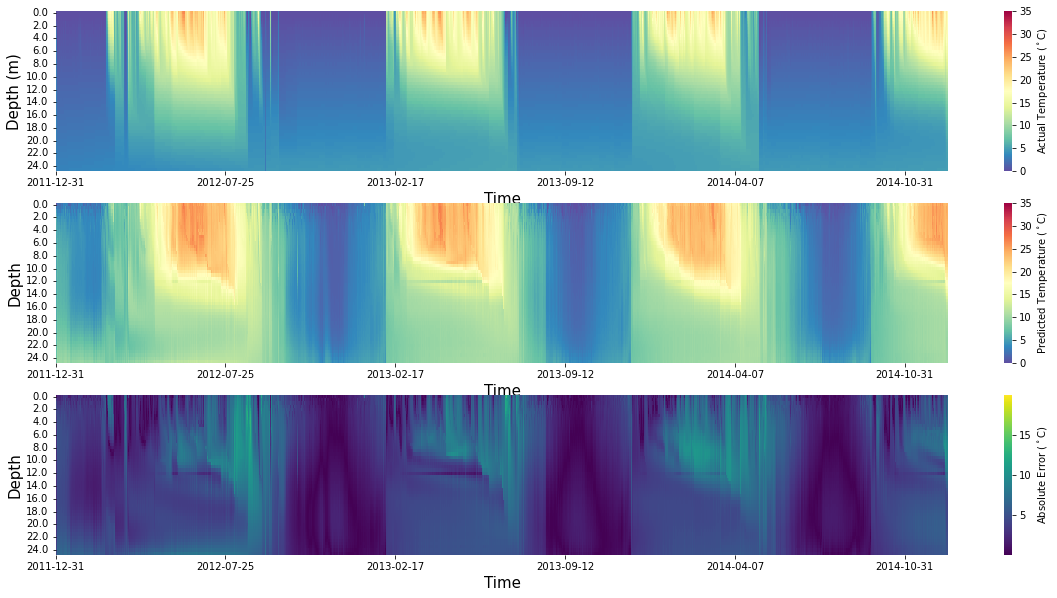

In [24]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

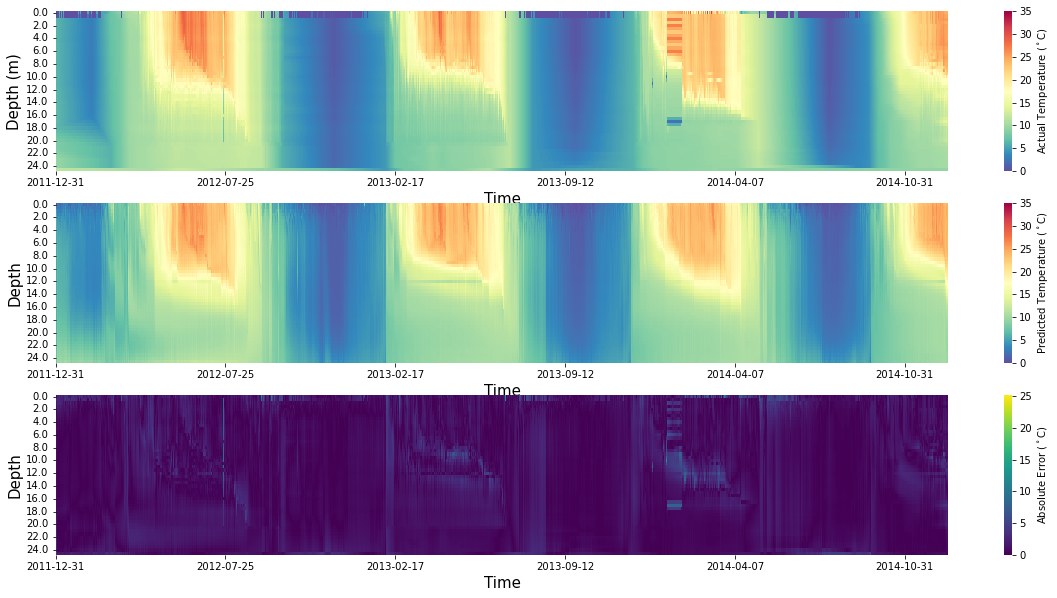

In [25]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [26]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0090550585
RMSE of after m1 0.016522184
RMSE of after m3 5.3468084
RMSE of after m4 6.745584
RMSE of after m0 0.010058648
RMSE of after m1 0.016627615
RMSE of after m3 5.4188
RMSE of after m4 6.7671056
RMSE of after m0 0.011175206
RMSE of after m1 0.018848468
RMSE of after m3 5.139082
RMSE of after m4 6.425837
RMSE of after m0 0.011941654
RMSE of after m1 0.019957943
RMSE of after m3 5.0505457
RMSE of after m4 6.331895
RMSE of after m0 0.011727795
RMSE of after m1 0.02048253
RMSE of after m3 4.993736
RMSE of after m4 6.2912283
RMSE of after m0 0.010224279
RMSE of after m1 0.019635735
RMSE of after m3 4.988462
RMSE of after m4 6.320519
RMSE of after m0 0.008626026
RMSE of after m1 0.01620574
RMSE of after m3 5.0048957
RMSE of after m4 6.2775884
RMSE of after m0 0.009490272
RMSE of after m1 0.015358796
RMSE of after m3 5.0221767
RMSE of after m4 6.2452307
RMSE of after m0 0.010674276
RMSE of after m1 0.017634274
RMSE of after m3 5.0804205
RMSE of after m4 6.345472
RMSE

RMSE of after m1 0.0056183287
RMSE of after m3 7.180041
RMSE of after m4 7.1440744
RMSE of after m0 0.0108512975
RMSE of after m1 0.011498152
RMSE of after m3 8.129722
RMSE of after m4 7.4736514
RMSE of after m0 0.012035362
RMSE of after m1 0.013494207
RMSE of after m3 9.679846
RMSE of after m4 8.346034
RMSE of after m0 0.010086248
RMSE of after m1 0.014489152
RMSE of after m3 9.870239
RMSE of after m4 8.413425
RMSE of after m0 0.010526003
RMSE of after m1 0.013280552
RMSE of after m3 8.91002
RMSE of after m4 7.9132533
RMSE of after m0 0.0064165476
RMSE of after m1 0.007993938
RMSE of after m3 7.300682
RMSE of after m4 7.0350513
RMSE of after m0 0.008246826
RMSE of after m1 0.009450231
RMSE of after m3 6.8127036
RMSE of after m4 6.6042514
RMSE of after m0 0.00856832
RMSE of after m1 0.008942973
RMSE of after m3 6.399427
RMSE of after m4 6.3318305
RMSE of after m0 0.0080105355
RMSE of after m1 0.007420443
RMSE of after m3 6.5164757
RMSE of after m4 6.457931
RMSE of after m0 0.00735115
R

RMSE of after m4 2.067849
RMSE of after m0 0.015327407
RMSE of after m1 0.02091872
RMSE of after m3 1.9809482
RMSE of after m4 1.8801914
RMSE of after m0 0.01415858
RMSE of after m1 0.015806895
RMSE of after m3 1.9210871
RMSE of after m4 1.8166301
RMSE of after m0 0.016523397
RMSE of after m1 0.014103757
RMSE of after m3 1.9787643
RMSE of after m4 1.8672804
RMSE of after m0 0.017184312
RMSE of after m1 0.016877146
RMSE of after m3 1.9381849
RMSE of after m4 1.85723
RMSE of after m0 0.017148841
RMSE of after m1 0.018557394
RMSE of after m3 1.7662742
RMSE of after m4 1.6918298
RMSE of after m0 0.016075712
RMSE of after m1 0.0139965415
RMSE of after m3 1.6014478
RMSE of after m4 1.541635
RMSE of after m0 0.017038234
RMSE of after m1 0.016146246
RMSE of after m3 1.5907052
RMSE of after m4 1.5280751
RMSE of after m0 0.018228516
RMSE of after m1 0.020548288
RMSE of after m3 2.1967926
RMSE of after m4 2.0559978
RMSE of after m0 0.01613603
RMSE of after m1 0.03826632
RMSE of after m3 2.2157805

RMSE of after m1 0.023409275
RMSE of after m3 1.8031068
RMSE of after m4 1.568836
RMSE of after m0 0.018936766
RMSE of after m1 0.02307606
RMSE of after m3 1.9819696
RMSE of after m4 1.7197765
RMSE of after m0 0.02063127
RMSE of after m1 0.026589442
RMSE of after m3 2.044405
RMSE of after m4 1.7717954
RMSE of after m0 0.02648403
RMSE of after m1 0.026995642
RMSE of after m3 1.8817874
RMSE of after m4 1.6217202
RMSE of after m0 0.025414173
RMSE of after m1 0.031857744
RMSE of after m3 1.7808867
RMSE of after m4 1.5340079
RMSE of after m0 0.022569383
RMSE of after m1 0.030776136
RMSE of after m3 1.796451
RMSE of after m4 1.5317334
RMSE of after m0 0.022294646
RMSE of after m1 0.031748474
RMSE of after m3 1.8448077
RMSE of after m4 1.5667884
RMSE of after m0 0.02064509
RMSE of after m1 0.026483301
RMSE of after m3 1.7247167
RMSE of after m4 1.4817979
RMSE of after m0 0.020849317
RMSE of after m1 0.028349517
RMSE of after m3 1.7233686
RMSE of after m4 1.4818319
RMSE of after m0 0.016641444

RMSE of after m4 3.552447
RMSE of after m0 0.009104912
RMSE of after m1 0.0076103723
RMSE of after m3 3.6038656
RMSE of after m4 3.56339
RMSE of after m0 0.008567678
RMSE of after m1 0.008075513
RMSE of after m3 3.532573
RMSE of after m4 3.5367496
RMSE of after m0 0.009218525
RMSE of after m1 0.00795007
RMSE of after m3 3.463568
RMSE of after m4 3.4810889
RMSE of after m0 0.0074404776
RMSE of after m1 0.0071046026
RMSE of after m3 3.4823365
RMSE of after m4 3.5051558
RMSE of after m0 0.007875259
RMSE of after m1 0.009868602
RMSE of after m3 3.454843
RMSE of after m4 3.4990995
RMSE of after m0 0.0066567427
RMSE of after m1 0.007961377
RMSE of after m3 3.3866522
RMSE of after m4 3.3971171
RMSE of after m0 0.008672425
RMSE of after m1 0.008255616
RMSE of after m3 3.2251265
RMSE of after m4 3.2513049
RMSE of after m0 0.008966252
RMSE of after m1 0.009039777
RMSE of after m3 3.3034775
RMSE of after m4 3.335861
RMSE of after m0 0.007659568
RMSE of after m1 0.008296456
RMSE of after m3 3.5370

RMSE of after m3 5.0228415
RMSE of after m4 5.760113
RMSE of after m0 0.01002703
RMSE of after m1 0.01837473
RMSE of after m3 5.0393724
RMSE of after m4 5.6411715
RMSE of after m0 0.009241676
RMSE of after m1 0.017203923
RMSE of after m3 4.9491553
RMSE of after m4 5.538332
RMSE of after m0 0.009590034
RMSE of after m1 0.017080458
RMSE of after m3 5.0040574
RMSE of after m4 5.6216726
RMSE of after m0 0.0091015985
RMSE of after m1 0.0143818725
RMSE of after m3 5.167725
RMSE of after m4 5.8610353
RMSE of after m0 0.009473817
RMSE of after m1 0.016675808
RMSE of after m3 5.0514708
RMSE of after m4 5.784462
RMSE of after m0 0.0106664235
RMSE of after m1 0.019191105
RMSE of after m3 5.1303196
RMSE of after m4 5.9084344
RMSE of after m0 0.011925627
RMSE of after m1 0.019214278
RMSE of after m3 5.2538185
RMSE of after m4 5.904491
RMSE of after m0 0.008975551
RMSE of after m1 0.017206542
RMSE of after m3 5.1742024
RMSE of after m4 5.84237
RMSE of after m0 0.01036379
RMSE of after m1 0.017499954

RMSE of after m0 0.00855818
RMSE of after m1 0.021236667
RMSE of after m3 4.7753053
RMSE of after m4 5.2998037
RMSE of after m0 0.01036932
RMSE of after m1 0.018321697
RMSE of after m3 4.79522
RMSE of after m4 5.1818113
RMSE of after m0 0.009405235
RMSE of after m1 0.017900372
RMSE of after m3 4.878202
RMSE of after m4 5.3177466
RMSE of after m0 0.009526361
RMSE of after m1 0.01419841
RMSE of after m3 5.090491
RMSE of after m4 5.6688986
RMSE of after m0 0.010422848
RMSE of after m1 0.016631389
RMSE of after m3 5.140358
RMSE of after m4 5.7730393
RMSE of after m0 0.010735834
RMSE of after m1 0.018385341
RMSE of after m3 5.2989216
RMSE of after m4 6.0410833
RMSE of after m0 0.010221515
RMSE of after m1 0.019010188
RMSE of after m3 5.157729
RMSE of after m4 5.8867264
RMSE of after m0 0.008593233
RMSE of after m1 0.014160954
RMSE of after m3 5.185784
RMSE of after m4 5.776822
RMSE of after m0 0.010008384
RMSE of after m1 0.015468521
RMSE of after m3 5.1839037
RMSE of after m4 5.79207
RMSE 

RMSE of after m3 5.452021
RMSE of after m4 5.0719337
RMSE of after m0 0.008098314
RMSE of after m1 0.008798604
RMSE of after m3 4.589483
RMSE of after m4 4.4665036
RMSE of after m0 0.013237107
RMSE of after m1 0.013106281
RMSE of after m3 5.668305
RMSE of after m4 5.1530085
RMSE of after m0 0.016642407
RMSE of after m1 0.039791703
RMSE of after m3 9.11653
RMSE of after m4 7.2882295
RMSE of after m0 0.019748256
RMSE of after m1 0.098601356
RMSE of after m3 9.038276
RMSE of after m4 6.9126353
RMSE of after m0 0.020018876
RMSE of after m1 0.08687679
RMSE of after m3 8.476083
RMSE of after m4 6.5483646
RMSE of after m0 0.01926663
RMSE of after m1 0.06457046
RMSE of after m3 8.489679
RMSE of after m4 6.530806
RMSE of after m0 0.017785776
RMSE of after m1 0.015185935
RMSE of after m3 7.738711
RMSE of after m4 6.0722575
RMSE of after m0 0.017693961
RMSE of after m1 0.016871635
RMSE of after m3 7.5215325
RMSE of after m4 5.9120874
RMSE of after m0 0.018127643
RMSE of after m1 0.019893166
RMSE 

RMSE of after m3 0.7703595
RMSE of after m4 0.68697006
RMSE of after m0 0.024566019
RMSE of after m1 0.02718351
RMSE of after m3 0.79285866
RMSE of after m4 0.7029432
RMSE of after m0 0.021844607
RMSE of after m1 0.02529575
RMSE of after m3 0.8016643
RMSE of after m4 0.7131719
RMSE of after m0 0.024181297
RMSE of after m1 0.025586048
RMSE of after m3 0.8279914
RMSE of after m4 0.7430225
RMSE of after m0 0.028725252
RMSE of after m1 0.027050585
RMSE of after m3 0.779572
RMSE of after m4 0.7003739
RMSE of after m0 0.029074952
RMSE of after m1 0.027694253
RMSE of after m3 0.7458601
RMSE of after m4 0.66849685
RMSE of after m0 0.025672523
RMSE of after m1 0.0256987
RMSE of after m3 0.8380831
RMSE of after m4 0.74891824
RMSE of after m0 0.02208245
RMSE of after m1 0.024560647
RMSE of after m3 0.7657705
RMSE of after m4 0.6805927
RMSE of after m0 0.021419208
RMSE of after m1 0.024929639
RMSE of after m3 0.85587
RMSE of after m4 0.7612293
RMSE of after m0 0.023166534
RMSE of after m1 0.025001

RMSE of after m1 0.0097516095
RMSE of after m3 2.301425
RMSE of after m4 2.3095806
RMSE of after m0 0.0082190605
RMSE of after m1 0.010800591
RMSE of after m3 2.424346
RMSE of after m4 2.3981853
RMSE of after m0 0.0075168894
RMSE of after m1 0.01038038
RMSE of after m3 2.5616589
RMSE of after m4 2.462599
RMSE of after m0 0.0066921776
RMSE of after m1 0.0106602935
RMSE of after m3 2.5788693
RMSE of after m4 2.464128
RMSE of after m0 0.007994442
RMSE of after m1 0.0071657742
RMSE of after m3 2.2423766
RMSE of after m4 2.3874
RMSE of after m0 0.008630675
RMSE of after m1 0.0069618747
RMSE of after m3 2.2232244
RMSE of after m4 2.3538873
RMSE of after m0 0.008193206
RMSE of after m1 0.007699726
RMSE of after m3 2.2548895
RMSE of after m4 2.3898015
RMSE of after m0 0.008325731
RMSE of after m1 0.00870077
RMSE of after m3 2.280449
RMSE of after m4 2.4253447
RMSE of after m0 0.007456354
RMSE of after m1 0.009114204
RMSE of after m3 2.3055604
RMSE of after m4 2.4732828
RMSE of after m0 0.00749

RMSE of after m1 0.012352541
RMSE of after m3 4.6085167
RMSE of after m4 5.527938
RMSE of after m0 0.009420361
RMSE of after m1 0.013959873
RMSE of after m3 4.5950317
RMSE of after m4 5.5552964
RMSE of after m0 0.017014742
RMSE of after m1 0.023894068
RMSE of after m3 4.584735
RMSE of after m4 5.681662
RMSE of after m0 0.009588451
RMSE of after m1 0.018617515
RMSE of after m3 4.4821277
RMSE of after m4 5.622575
RMSE of after m0 0.008172966
RMSE of after m1 0.016760927
RMSE of after m3 4.4833236
RMSE of after m4 5.5860415
RMSE of after m0 0.008411063
RMSE of after m1 0.013968216
RMSE of after m3 4.580843
RMSE of after m4 5.6642165
RMSE of after m0 0.00971563
RMSE of after m1 0.015768103
RMSE of after m3 4.605527
RMSE of after m4 5.725524
RMSE of after m0 0.011323469
RMSE of after m1 0.017906269
RMSE of after m3 4.541012
RMSE of after m4 5.6674953
RMSE of after m0 0.011169926
RMSE of after m1 0.018527897
RMSE of after m3 4.516067
RMSE of after m4 5.672804
RMSE of after m0 0.010345645
RMS

RMSE of after m1 0.0153117385
RMSE of after m3 5.8809376
RMSE of after m4 7.034001
RMSE of after m0 0.0073787696
RMSE of after m1 0.014294841
RMSE of after m3 5.8142443
RMSE of after m4 6.9188247
RMSE of after m0 0.008898086
RMSE of after m1 0.013166777
RMSE of after m3 5.9666514
RMSE of after m4 7.0098915
RMSE of after m0 0.009080274
RMSE of after m1 0.013665017
RMSE of after m3 5.89118
RMSE of after m4 6.9564676
RMSE of after m0 0.009404748
RMSE of after m1 0.014519604
RMSE of after m3 5.861577
RMSE of after m4 6.9456143
RMSE of after m0 0.008970909
RMSE of after m1 0.01577015
RMSE of after m3 5.7710857
RMSE of after m4 6.864251
RMSE of after m0 0.009357024
RMSE of after m1 0.017375147
RMSE of after m3 5.568
RMSE of after m4 6.6965504
RMSE of after m0 0.008433183
RMSE of after m1 0.015882209
RMSE of after m3 5.469571
RMSE of after m4 6.5511966
RMSE of after m0 0.009921665
RMSE of after m1 0.015646378
RMSE of after m3 5.5116596
RMSE of after m4 6.55942
RMSE of after m0 0.010331152
RMS

RMSE of after m4 6.3917327
RMSE of after m0 0.018138977
RMSE of after m1 0.021034833
RMSE of after m3 6.208836
RMSE of after m4 5.2790847
RMSE of after m0 0.014523519
RMSE of after m1 0.01853953
RMSE of after m3 5.9254417
RMSE of after m4 5.075859
RMSE of after m0 0.017220307
RMSE of after m1 0.01874232
RMSE of after m3 5.867473
RMSE of after m4 5.0225105
RMSE of after m0 0.019489218
RMSE of after m1 0.022382462
RMSE of after m3 5.9137907
RMSE of after m4 5.0356965
RMSE of after m0 0.018172065
RMSE of after m1 0.021128418
RMSE of after m3 5.838601
RMSE of after m4 4.9635863
RMSE of after m0 0.016827852
RMSE of after m1 0.019113297
RMSE of after m3 5.6885567
RMSE of after m4 4.8654594
RMSE of after m0 0.01310371
RMSE of after m1 0.017475897
RMSE of after m3 5.35648
RMSE of after m4 4.6648517
RMSE of after m0 0.016019547
RMSE of after m1 0.01862794
RMSE of after m3 5.374699
RMSE of after m4 4.7023964
RMSE of after m0 0.01609223
RMSE of after m1 0.018118989
RMSE of after m3 5.3370266
RMSE

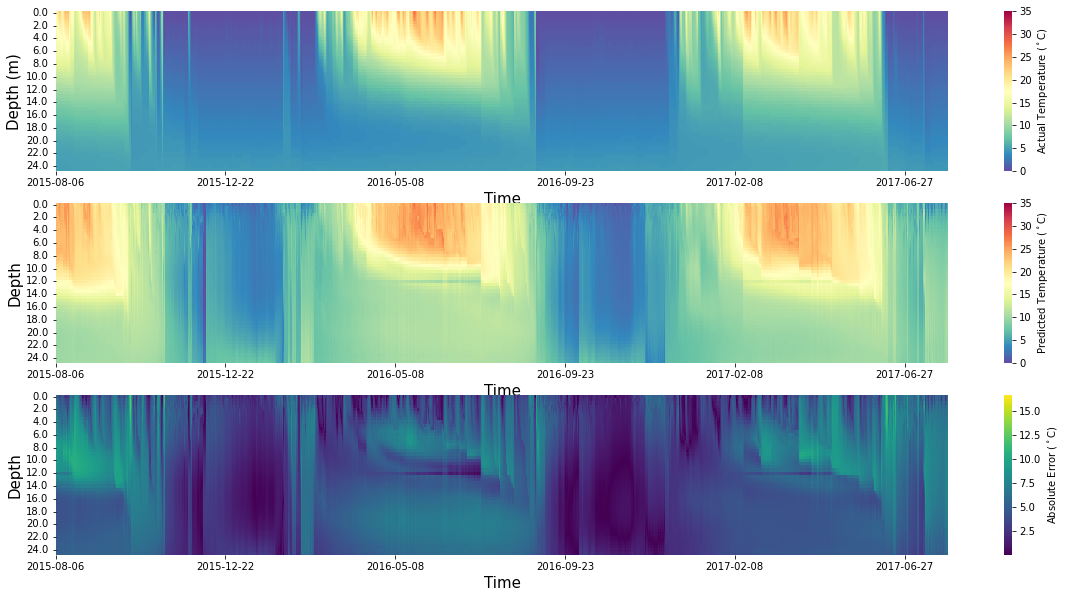

In [27]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

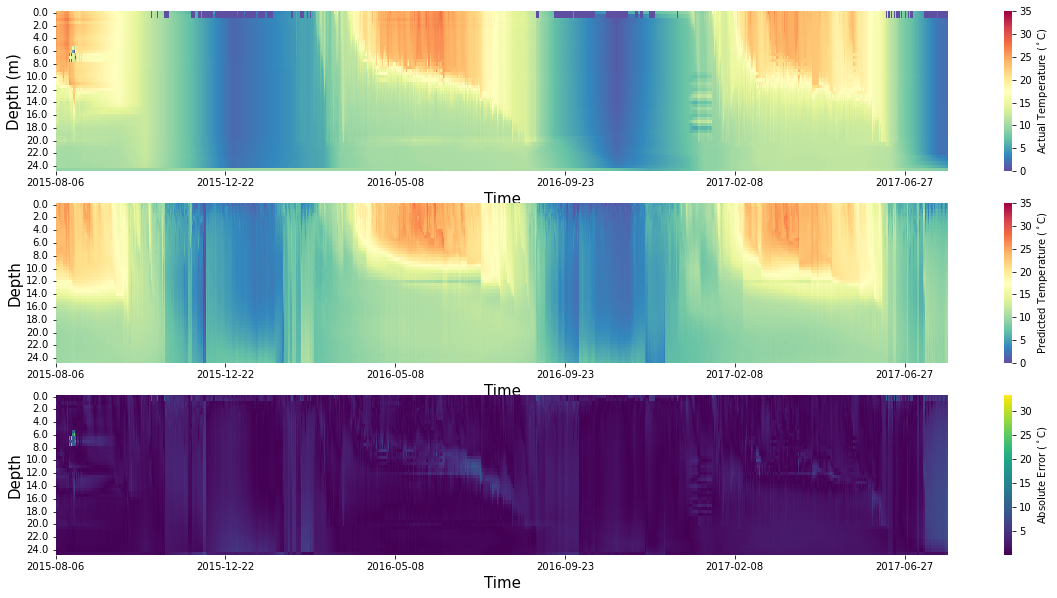

In [28]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [29]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 4.555871016901205, Train L2 Error: 0.5999380529779642
Test RMSE: 4.81928660966558, Train L2 Error: 0.605854504720045


## Mixing Model

## Convection Model

In [30]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.016564466585520927, Train L2 Error: 0.0021814161585095035
Test RMSE: 0.018082867571663358, Train L2 Error: 0.0022734152265340805


## Ice Model

In [31]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.014016497076078948, Train L2 Error: 0.0018445259825475508
Test RMSE: 0.01633510608431941, Train L2 Error: 0.0020521246787989266


In [47]:
def plot_output_test(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    times = time_label
    
    print(times)
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)


    sns.heatmap(y_pred.T, ax=ax, cmap='Spectral_r', vmin=0., vmax=35.)
    ax.set_ylabel("Depth (m)", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    
    #  plt.legend(fontsize='x-large', title_fontsize='40')
    # ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    # ax.set_xticklabels(time_label, rotation=0)
    # new insert
    xticks_ix = np.array(ax.get_xticks()).astype(int)
    
    print(xticks_ix)
    
    time_label = times[xticks_ix]
    
    print(time_label)
    

    nelement = len(time_label)//N_pts

    print(nelement)

    time_label = time_label[::nelement]

    print(time_label)

    ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))

    xticks_ix = np.array(ax.get_xticks()).astype(int)

    print(xticks_ix)
    #
    time_label = times[xticks_ix[xticks_ix < len(times)]]

    ax.set_xticklabels(time_label, rotation=0, fontsize = 15)
    # old code

    ax.collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)", fontsize = 15)

    yticks_ix = np.array(ax.get_yticks()).astype(int)
    
    print(yticks_ix)
    
    # depth_label = depth_steps / 25
    depth_label = yticks_ix / 2
    
    print(depth_label)
    
    nelement = len(depth_label)//5
    
    print(nelement)
    
    depth_label = depth_label[::nelement]
    
    print(depth_label)
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_yticklabels(depth_label, rotation=0, fontsize = 15)

    plt.show()

['2015-08-06' '2015-08-06' '2015-08-06' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
[    0   397   794  1191  1588  1985  2382  2779  3176  3573  3970  4367
  4764  5161  5558  5955  6352  6749  7146  7543  7940  8337  8734  9131
  9528  9925 10322 10719 11116 11513 11910 12307 12704 13101 13498 13895
 14292 14689 15086 15483 15880 16277 16674 17071 17468 17865 18262 18659
 19056 19453 19850 20247 20644]
['2015-08-06' '2015-08-22' '2015-09-08' '2015-09-24' '2015-10-11'
 '2015-10-27' '2015-11-13' '2015-11-29' '2015-12-16' '2016-01-01'
 '2016-01-18' '2016-02-03' '2016-02-20' '2016-03-08' '2016-03-24'
 '2016-04-10' '2016-04-26' '2016-05-13' '2016-05-29' '2016-06-15'
 '2016-07-01' '2016-07-18' '2016-08-03' '2016-08-20' '2016-09-06'
 '2016-09-22' '2016-10-09' '2016-10-25' '2016-11-11' '2016-11-27'
 '2016-12-14' '2016-12-30' '2017-01-16' '2017-02-01' '2017-02-18'
 '2017-03-06' '2017-03-23' '2017-04-08' '2017-04-25' '2017-05-12'
 '2017-05-28' '2017-06-14' '2017-06-30' '2017-07-17' '2017-08-0

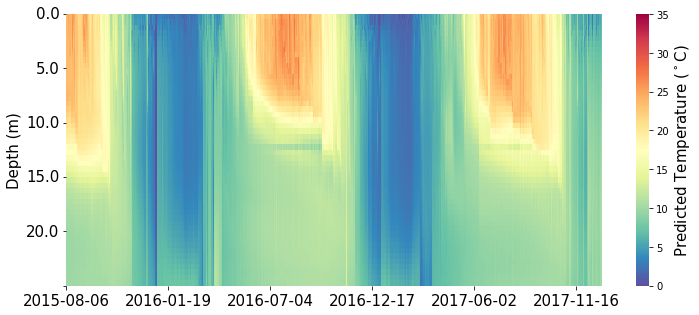

In [49]:
plot_output_test(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(12,5))

In [38]:
print(test_time)
print(depth_steps)
time_label = np.array([time[:10] for time in test_time])
print(time_label)
time_label = time_label[::depth_steps]
print(time_label)

1577100    2015-08-06 02:00:00
1577101    2015-08-06 02:00:00
1577102    2015-08-06 02:00:00
1577103    2015-08-06 02:00:00
1577104    2015-08-06 02:00:00
                  ...         
2628545    2017-12-28 23:00:00
2628546    2017-12-28 23:00:00
2628547    2017-12-28 23:00:00
2628548    2017-12-28 23:00:00
2628549    2017-12-28 23:00:00
Name: time, Length: 1051450, dtype: object
50
['2015-08-06' '2015-08-06' '2015-08-06' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
['2015-08-06' '2015-08-06' '2015-08-06' ... '2017-12-28' '2017-12-28'
 '2017-12-28']


# Finetuning

# Freeze model weights